In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tpot as tp
import imblearn
from collections import Counter
from tpot import TPOTClassifier, TPOTRegressor
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids 
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN 
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier


In [3]:
bc2 = pd.read_csv('bc_data.csv', header = [1])
bc2.drop(['Diagnosis','id_number.1'], axis = 1, inplace = True)
bc2.set_index('id_number', inplace = True)
bc_data_with_dummies = pd.get_dummies(bc2)

In [4]:
bc_data_full = bc_data_with_dummies.interpolate(method = 'linear',axis = 1)

In [5]:
bc_data_full.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitosis,Class,radius,...,Bare Nuclei_10,Bare Nuclei_2,Bare Nuclei_3,Bare Nuclei_4,Bare Nuclei_5,Bare Nuclei_6,Bare Nuclei_7,Bare Nuclei_8,Bare Nuclei_9,Bare Nuclei_?
id_number,,,,,,,,,,,,,,,,,,,,,
1000025,5.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,2.0,17.99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002945,5.0,4.0,4.0,5.0,7.0,3.0,2.0,1.0,2.0,20.57,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1015425,3.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,2.0,19.69,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1016277,6.0,8.0,8.0,1.0,3.0,3.0,7.0,1.0,2.0,11.42,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1017023,4.0,1.0,1.0,3.0,2.0,3.0,1.0,1.0,2.0,20.29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
bc_data_full.columns

Index(['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bland Chromatin', 'Normal Nucleoli',
       'Mitosis', 'Class', 'radius', 'mean_radius', 'texture', 'mean_texture',
       'perimeter', 'mean_perimeter', 'area', 'mean_area', 'smoothness',
       'mean_smoothness', 'compactness', 'mean_compactness', 'concavity',
       'mean_concavity', 'concave_points', 'mean_concave_points', 'symmetry',
       'mean_symmetry', 'fractal_dimension', 'mean_fractal_dimension',
       'Bare Nuclei_1', 'Bare Nuclei_10', 'Bare Nuclei_2', 'Bare Nuclei_3',
       'Bare Nuclei_4', 'Bare Nuclei_5', 'Bare Nuclei_6', 'Bare Nuclei_7',
       'Bare Nuclei_8', 'Bare Nuclei_9', 'Bare Nuclei_?'],
      dtype='object')

In [75]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [7]:
#split into training and testing set
features = ['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bland Chromatin', 'Normal Nucleoli',
       'Mitosis', 'radius', 'mean_radius', 'texture', 'mean_texture',
       'perimeter', 'mean_perimeter', 'area', 'mean_area', 'smoothness',
       'mean_smoothness', 'compactness', 'mean_compactness', 'concavity',
       'mean_concavity', 'concave_points', 'mean_concave_points', 'symmetry',
       'mean_symmetry', 'fractal_dimension', 'mean_fractal_dimension',
       'Bare Nuclei_1', 'Bare Nuclei_10', 'Bare Nuclei_2', 'Bare Nuclei_3',
       'Bare Nuclei_4', 'Bare Nuclei_5', 'Bare Nuclei_6', 'Bare Nuclei_7',
       'Bare Nuclei_8', 'Bare Nuclei_9', 'Bare Nuclei_?']
X = bc_data_full[features]
y = bc_data_full['Class']
features_train,features_test,target_train,target_test = train_test_split(X,y, test_size = .25, random_state = 1 )

In [8]:
#Standardization before applying PCA
scaler = StandardScaler()
X_train = scaler.fit_transform(features_train)
print(X_train)

[[ 1.24812634 -0.05678383  0.24996077 ... -0.18311355 -0.09815249
  -0.15309311]
 [ 1.24812634  0.59716622  0.92165021 ... -0.18311355 -0.09815249
  -0.15309311]
 [ 1.24812634  1.5780913   1.92918438 ... -0.18311355 -0.09815249
  -0.15309311]
 ...
 [-1.24676599 -0.05678383 -0.08588396 ... -0.18311355 -0.09815249
  -0.15309311]
 [-0.53393961 -0.71073388  0.24996077 ... -0.18311355 -0.09815249
   6.53197265]
 [ 0.53529996 -0.38375886 -0.7575734  ... -0.18311355 -0.09815249
  -0.15309311]]


In [9]:
scaler2 = StandardScaler()
X_test = scaler2.fit_transform(features_test)


In [10]:
pca_columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20','PC21','PC22','PC23','PC24','PC25','PC26','PC27','PC28','PC29']

In [11]:
#Fitting training PCA
pca = PCA(n_components=29)
X_train_pca = pca.fit_transform(X_train)
principalDF = pd.DataFrame(data = X_train_pca, columns = pca_columns )
print("original shape:   ", X_train.shape)
print("transformed shape:", X_train_pca.shape)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

#plot_2d_space(pca_result, y, ' 29 PCA components')

original shape:    (524, 39)
transformed shape: (524, 29)
Explained variation per principal component: [3.82495575e-01 1.62986727e-01 7.33323720e-02 3.24405923e-02
 3.02020595e-02 2.95677102e-02 2.80801540e-02 2.73948168e-02
 2.67846394e-02 2.65584993e-02 2.63982703e-02 2.61352166e-02
 2.30229296e-02 1.93696049e-02 1.49190850e-02 1.28478226e-02
 1.16281071e-02 9.96021439e-03 8.31837721e-03 7.86937974e-03
 6.29411037e-03 6.07289501e-03 3.41449257e-03 2.02799630e-03
 1.31842518e-03 2.28791684e-04 1.59863683e-04 1.00025535e-04
 2.62971797e-05]


In [16]:
#fitting testing PCA
pca2 = PCA(n_components = 29)
X_test_pca = pca2.fit_transform(X_test)
testprincipalDF = pd.DataFrame(data = X_test_pca, columns = pca_columns)
print("original shape:   ", features_test.shape)
print("transformed shape:", X_test_pca.shape)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))



original shape:    (175, 39)
transformed shape: (175, 29)
Explained variation per principal component: [3.82495575e-01 1.62986727e-01 7.33323720e-02 3.24405923e-02
 3.02020595e-02 2.95677102e-02 2.80801540e-02 2.73948168e-02
 2.67846394e-02 2.65584993e-02 2.63982703e-02 2.61352166e-02
 2.30229296e-02 1.93696049e-02 1.49190850e-02 1.28478226e-02
 1.16281071e-02 9.96021439e-03 8.31837721e-03 7.86937974e-03
 6.29411037e-03 6.07289501e-03 3.41449257e-03 2.02799630e-03
 1.31842518e-03 2.28791684e-04 1.59863683e-04 1.00025535e-04
 2.62971797e-05]


In [15]:
len(principalDF.PC1)

524

In [17]:
eig_values = pca.explained_variance_
eig_vectors = pca.components_
print(eig_values)
print(eig_vectors)

[1.49458500e+01 6.36863625e+00 2.86543089e+00 1.26760219e+00
 1.18013248e+00 1.15534556e+00 1.09721994e+00 1.07044068e+00
 1.04659826e+00 1.03776193e+00 1.03150106e+00 1.02122235e+00
 8.99611069e-01 7.56858980e-01 5.82956828e-01 5.02023139e-01
 4.54363284e-01 3.89191092e-01 3.25037011e-01 3.07492628e-01
 2.45939655e-01 2.37295760e-01 1.33419828e-01 7.92430829e-02
 5.15168968e-02 8.93993663e-03 6.24660464e-03 3.90845476e-03
 1.02755098e-03]
[[-0.03448161 -0.01618502 -0.01963067 ... -0.01150041 -0.01240028
  -0.01925216]
 [ 0.294239    0.36416576  0.36097177 ...  0.09286093  0.0410768
  -0.0114732 ]
 [-0.03481445 -0.00694735  0.01312034 ... -0.01006279 -0.05810507
  -0.03168157]
 ...
 [ 0.00105181 -0.01763708  0.00376703 ... -0.00067354 -0.0025298
   0.00406315]
 [-0.00165534 -0.00850393  0.00826052 ... -0.0021773  -0.00373302
   0.0043426 ]
 [-0.00221506 -0.00148192  0.00097179 ...  0.00123651  0.00141878
  -0.00086797]]


In [274]:
eig_vectors[1]

array([ 0.294239  ,  0.36416576,  0.36097177,  0.3145847 ,  0.3079558 ,
        0.32852915,  0.31329384,  0.20180371, -0.00332383, -0.00363067,
       -0.01392093, -0.01103944,  0.07059739,  0.0679157 ,  0.06522129,
        0.05963616,  0.05821078,  0.05068042,  0.04878665,  0.04127088,
        0.00218548, -0.00945107,  0.01448004,  0.00480162, -0.00637172,
       -0.02136894, -0.03695744, -0.05288739, -0.30752515,  0.24946284,
        0.01416227,  0.01913559,  0.03500514,  0.0670973 ,  0.0451606 ,
        0.03928555,  0.09286093,  0.0410768 , -0.0114732 ])

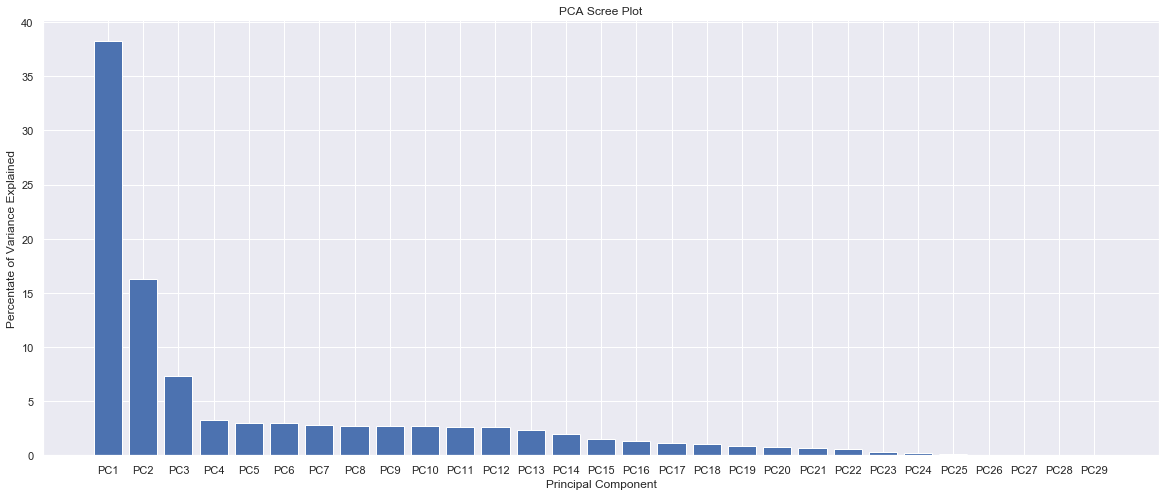

In [18]:
sns.set()
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
plt.figure(figsize=(20,8))
plt.bar(x= range(1,30), height=percent_variance, tick_label=pca_columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')

plt.show()

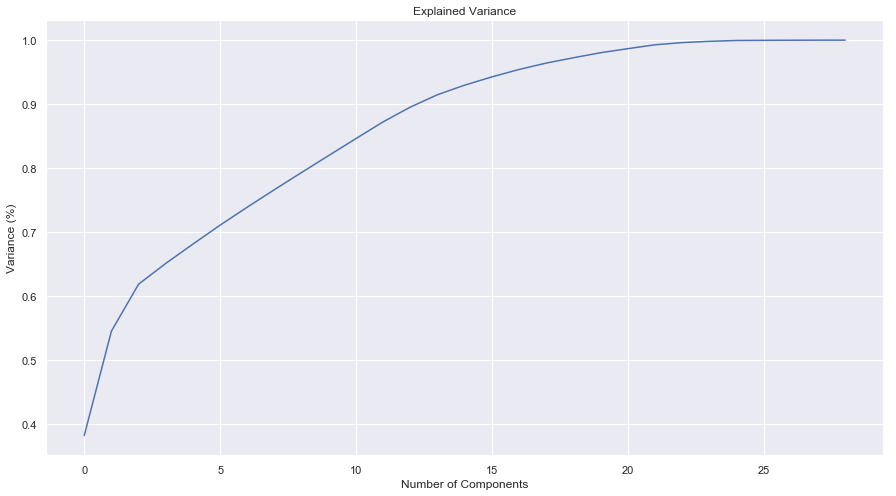

In [19]:
plt.figure(figsize = (15,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()

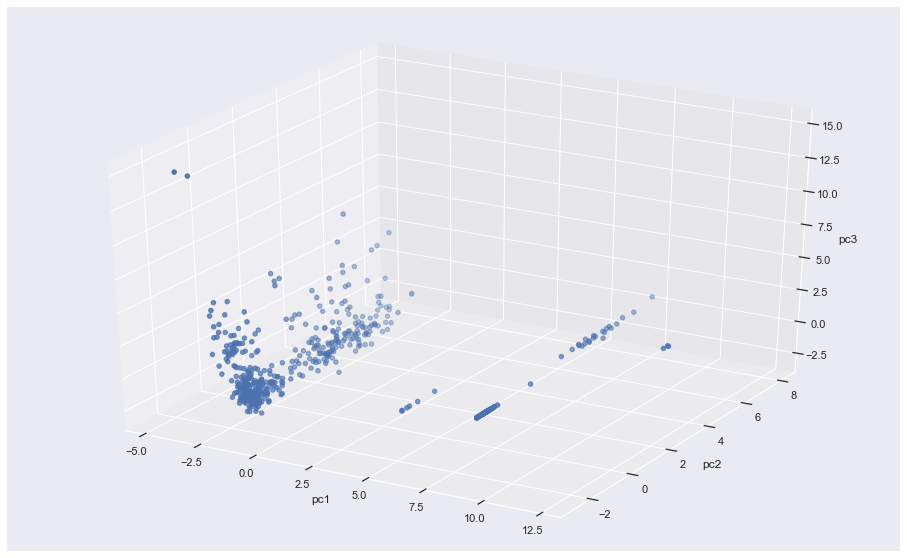

In [20]:
#plot 3 of the pca components to visualize
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=principalDF['PC1'], 
    ys=principalDF['PC2'], 
    zs=principalDF['PC3'], 
#     c= 'y', 
    cmap='tab10'
)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.show()

In [47]:
#examine the components
pc1 = pca.components_[0]
pc2 = pca.components_[1] 
pc3 = pca.components_[2] 
pc4 = pca.components_[3] 
pc5 = pca.components_[4] 
pc6 = pca.components_[5] 
pc7 = pca.components_[6] 
pc8 = pca.components_[7] 
pc9 = pca.components_[8] 
pc10 = pca.components_[9] 
pc11 = pca.components_[10] 
pc12 = pca.components_[11] 
pc13 = pca.components_[12]

In [275]:
# get the loadings
structure_loading_2 = pc2* np.sqrt(eig_values[1])
str_loading_2 = pd.Series(structure_loading_2, index=features)
str_loading_2.sort_values(ascending = False)

Uniformity of Cell Size        0.919014
Uniformity of Cell Shape       0.910954
Bland Chromatin                0.829081
Marginal Adhesion              0.793891
Normal Nucleoli                0.790633
Single Epithelial Cell Size    0.777162
Clump Thickness                0.742546
Bare Nuclei_10                 0.629548
Mitosis                        0.509275
Bare Nuclei_8                  0.234345
perimeter                      0.178161
mean_perimeter                 0.171393
Bare Nuclei_5                  0.169328
area                           0.164593
mean_area                      0.150499
smoothness                     0.146902
mean_smoothness                0.127898
compactness                    0.123119
Bare Nuclei_6                  0.113968
mean_compactness               0.104152
Bare Nuclei_9                  0.103662
Bare Nuclei_7                  0.099142
Bare Nuclei_4                  0.088340
Bare Nuclei_3                  0.048291
concave_points                 0.036542


In [26]:
pc_to_drop = ['PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28',
       'PC29']
pca_train_df = principalDF.drop(pc_to_drop, axis = 1)

In [28]:
pca_test_df = testprincipalDF.drop(pc_to_drop, axis = 1)

In [30]:

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(pca_train_df, target_train)
print(sorted(Counter(y_sm).items()))

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

[(2.0, 340), (4.0, 340)]


NameError: name 'plot_2d_space' is not defined

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
logreg = LogisticRegression()
param_grid = {
    "penalty":["l1",'l2'],
    "C": [0.001,0.01,0.1,1,10,100,1000]
}


In [31]:
lr_grid_search = GridSearchCV(logreg,param_grid,cv = 5, return_train_score= True)
lr_grid_search.fit(X_sm,y_sm)

/Users/harrisonmiller/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/harrisonmiller/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/harrisonmiller/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/harrisonmiller/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/harrisonmiller/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [32]:
lr_gs_training_score = np.mean(lr_grid_search.cv_results_['mean_train_score'])
lr_gs_testing_score = lr_grid_search.score(X_sm, y_sm)

print("Mean Training Score: {:.4}%".format(lr_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(lr_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
lr_grid_search.best_params_

Mean Training Score: 94.13%
Mean Testing Score: 97.65%
Best Parameter Combination Found During Grid Search:


{'C': 0.001, 'penalty': 'l2'}

In [55]:
tuned_logreg = LogisticRegression(penalty='l2',C=0.001,solver='liblinear')
tuned_logreg.fit(X_sm,y_sm)
logreg_preds = tuned_logreg.predict(pca_test_df)
accuracy = accuracy_score(target_test, logreg_preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.00%


In [56]:
def plot_confusion_matrix(y_test,model_pred):
    conf_mat = confusion_matrix(y_true=y_test, y_pred=model_pred)
    #print('Confusion matrix:\n', conf_mat)

    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g', cmap = 'Greens'); 

    # labels, title and ticks
    ax.set_xlabel('Predicted');ax.set_ylabel('Expected'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Benign', 'Malignant']); ax.yaxis.set_ticklabels(['Benign', 'Malignant']);
    print(classification_report(y_test,model_pred))

              precision    recall  f1-score   support

         2.0       0.99      0.95      0.97       118
         4.0       0.90      0.98      0.94        57

    accuracy                           0.96       175
   macro avg       0.95      0.97      0.96       175
weighted avg       0.96      0.96      0.96       175



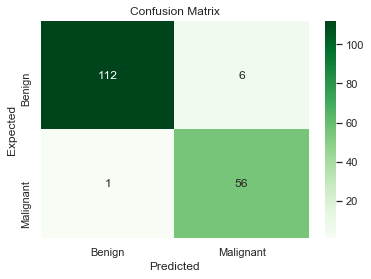

In [57]:
plot_confusion_matrix(target_test,logreg_preds)

In [58]:
def plot_feature_importances(model):
    n_features = pca_train_df.shape[1]
    plt.figure(figsize=(8,15))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), pca_train_df.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [60]:
def plot_ROC_curve(x_test,y_test,model):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    probs = model.predict_proba(x_test)
    probs = probs[:,1]
    fpr, tpr, thresholds = roc_curve(y_test,probs, pos_label= 4)
    auc = roc_auc_score(y_test, probs)
    plt.figure(figsize=(12,8))
    plt.title("ROC",fontsize = 14)
    plt.xlabel("FPR", fontsize = 12)
    plt.ylabel("TPR", fontsize = 12)
    plt.plot([0,1],[0,1], linestyle='--')
    plt.plot(fpr, tpr, marker = '.', linewidth = 4)
    plt.legend(["AUC=%.3f"%auc],loc = 'lower right',prop={'size': 30})
    plt.show()

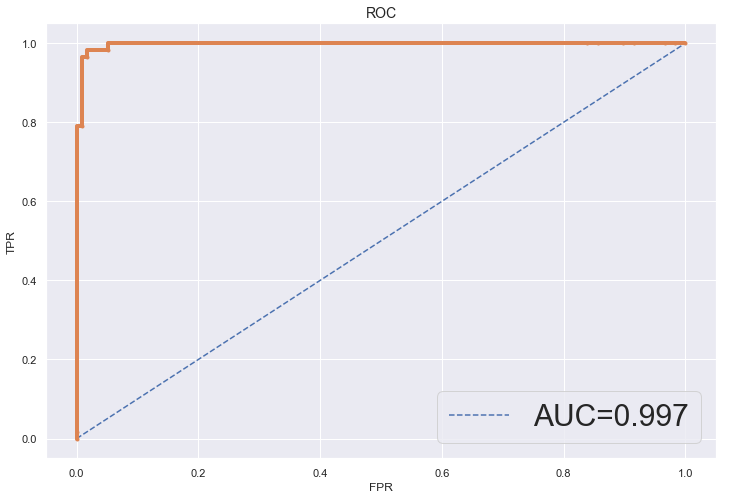

In [61]:
plot_ROC_curve(pca_test_df,target_test,tuned_logreg)